<a href="https://colab.research.google.com/github/RomainHugues/Ship_simulator/blob/master/ship_simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installs and imports

In [121]:
import pandas

try:
    import geopandas
except ImportError:
    !pip install geopandas
    import geopandas


import xarray

try:
    import cfgrib
except ImportError:
    !sudo apt-get install libeccodes0
    !pip install cfgrib
    import cfgrib

import numpy
from scipy import interpolate
import os

from datetime import datetime, timedelta
import shapely
import random
import time

try:
    import geemap.eefolium as geemap
except ImportError:
    !pip install geemap
    import geemap.eefolium as geemap

import ee

from matplotlib import pyplot as plt

from google.colab import drive


Environment classes : Wind and Current

In [122]:
class Wind:

    def __init__(self):
        
        self.dimensions = None
        self.latitude = None
        self.longitude = None
        self.timestep = None
        self.wind_data = None

    def acquire_grib_data(self, grib_file_location):

        wind_dataset = cfgrib.open_dataset(grib_file_location)

        # Grid dimension
        self.dimensions = numpy.array([wind_dataset.dims['step'], wind_dataset.dims['latitude'], wind_dataset.dims['longitude']])
        # Grid coordinates
        self.latitude = wind_dataset.coords['latitude']
        self.longitude = wind_dataset.coords['longitude']
        self.timestep = wind_dataset.coords['step']
        
        # Grid data
        self.wind_data = wind_dataset.data_vars

    def get_wind_info_from_position(self, position, date):

        # Eastwards component
        wind_position_u = self.wind_data['u10'].interp(latitude = position.coordinates[0], 
                                                            longitude = position.coordinates[1],
                                                            step = (date - self.wind_data['u10'].time))

        # Northwards component
        wind_position_v = self.wind_data['v10'].interp(latitude = position.coordinates[0], 
                                                            longitude = position.coordinates[1],
                                                            step = (date - self.wind_data['v10'].time))

        wind_direction = (90 - numpy.arctan2(wind_position_v, wind_position_u) * 180 / numpy.pi) % 360
        wind_speed = numpy.sqrt(wind_position_u**2 + wind_position_v**2)

        return wind_speed.data, wind_direction.data 

class Current:

    def __init__(self):

        current_field = None

    def acquire_current_data(self):

        return 0

    def delta_speed_from_position(self):

        return 0
    

Position class

In [123]:
class Position:

    def __init__(self, lat, lon):

        self.coordinates = numpy.array([lat,lon],dtype=numpy.float32) 

    def update(self, heading, speed, delta_T=60):
        
        R = 6371e3
        # Update position for ship bearing heading with given speed during delta_T seconds
        [phi1, lambda1] = self.coordinates * numpy.pi / 180
        # distance in meters
        distance = (speed * 1852 / 3600) * delta_T
        # Angular distance
        delta = distance / R

        #Bearing
        theta = heading * numpy.pi / 180

        phi2 = numpy.arcsin(numpy.sin(phi1)*numpy.cos(delta)+numpy.cos(phi1)*numpy.sin(delta)*numpy.cos(theta)) * 180 / numpy.pi
        lambda2 = (lambda1 + numpy.arctan2(numpy.sin(theta)*numpy.sin(delta)*numpy.cos(phi1), numpy.cos(delta)-numpy.sin(phi1)*numpy.sin(phi2))) * 180 / numpy.pi
        
        self.coordinates = numpy.array([phi2,lambda2])

        return distance


Ship class

In [124]:
class Ship:

    def __init__(self, starting_point, starting_date):

        self.heading = 0
        self.position = starting_point
        self.date = starting_date
        self.speed = 0
        self.polar_best_speed = None
        self.wind_relative_angle = 0

        self.heading_track = [self.heading]
        self.position_track = [self.position.coordinates]
        self.speed_track = [self.speed]
        self.cumulated_distance = 0

    def update_date(self, delta_T_seconds):

        self.date += timedelta(seconds=delta_T_seconds) 

    def acquire_polar_data(self,polar_data_file):

        polar_csv = pandas.read_csv(polar_file_location)

        polar_speed = numpy.zeros([181,71,5])

        for i in range(181*71*5-1):
            polar_speed[int(polar_csv.iloc[i, 2]),int(polar_csv.iloc[i, 0]),int(polar_csv.iloc[i, 1]) - 1] = polar_csv.iloc[i, 3]

        polar_best_sail = numpy.argmax(polar_speed, axis=2).squeeze()
        polar_best_speed = numpy.max(polar_speed, axis=2).squeeze()

        # Interpolation function
        self.polar_best_speed = interpolate.interp2d(y=numpy.arange(181),
                                                           x=numpy.arange(71),
                                                           z=polar_best_speed,
                                                           kind='cubic')

    def get_speed(self, wind_speed, wind_direction):

        # Wind relative angle
        wind_relative_angle = numpy.abs((self.heading - wind_direction) % 180)

        self.wind_relative_angle = wind_relative_angle

        # Ship speed
        self.speed = round(self.polar_best_speed(wind_speed, wind_relative_angle)[0],2)

        self.speed_track.append(self.speed)

    def set_heading(self,new_heading):

        self.heading = new_heading
        self.heading_track.append(self.heading)

    def set_starting_point(self,starting_point):

        self.position = starting_point
        self.position_track.append(self.position.coordinates)

    def update_position(self, delta_T):

        distance = self.position.update(self.heading, self.speed, delta_T)
        self.position_track.append(self.position.coordinates)
        self.cumulated_distance +=distance

In [125]:
class Navigator:

    def __init__(self, mode):

        self.heading = 0
        self.mode = mode

    def heading_update(self,route, ship, wind_speed, wind_direction):

        if self.mode == 'shortest':
            # Heading is bearing towards next checkpoint
            self.heading = route.bearing_to_next_checkpoint
        
        elif self.mode == 'vmg':

            # Heading to next checkpoint maximizing VMG
            
            # Getting ship speed for given wind speed
            wind_relative_angle_range = numpy.arange(181,dtype=numpy.float32)
            half_speed_range = ship.polar_best_speed(wind_speed, wind_relative_angle_range).flat

            speed_range = numpy.hstack([half_speed_range[::-1],half_speed_range[1:-1]])
            heading_range = (numpy.arange(-180,180) + wind_direction) % 360

            # Projecting toward next checkpoint bearing point (VMG or Velocity Made Good)

            cos_delta_angle = numpy.cos( (heading_range-route.bearing_to_next_checkpoint) * numpy.pi / 180)
            vmg_range = speed_range * cos_delta_angle

            # Getting Heading Maximizing VMG
            imax_vmg_range = numpy.argmax(vmg_range)
            best_heading = heading_range[imax_vmg_range]

            self.heading = best_heading

        else:

            self.heading = 0


Route class

In [126]:
class Route:

    def __init__(self):

        self.checkpoint_list = []
        self.bearing_list = None
        self.distances_list = None
        self.minimal_distance = None
        self.route_status = 0

        self.bearing_to_next_checkpoint = 0
        self.distance_to_next_checkpoint = 0

    def set_starting_point(self,point):

        self.checkpoint_list = [point]

    def add_checkpoint(self,point):

        self.checkpoint_list.append(point)

    def remove_checkpoint(self,index):

        self.checkpoint_list.pop(index)

    def insert_checkpoint(self,index, point):

        self.checkpoint_list.insert(index, point)

    def bearing_and_distance(self):

        # compute bearing and distance from starting point to endpoint through all checkpoints

        R = 6371e3
        array_road = numpy.stack(self.checkpoint_list)

        point_1 = array_road[:-1,:]
        point_2 = array_road[1:,:]

        phi1 = point_1[:,0] * numpy.pi / 180
        phi2 = point_2[:,0] * numpy.pi / 180
        delta_phi = phi2 - phi1
        lambda1 = point_1[:,1] * numpy.pi / 180
        lambda2 = point_2[:,1] * numpy.pi / 180
        delta_lambda = lambda2 - lambda1

        # Distance

        a = numpy.sin(delta_phi/2)**2+numpy.cos(phi1)*numpy.cos(phi2)*numpy.sin(delta_lambda/2)**2
        c = 2 * numpy.arctan2(numpy.sqrt(a), numpy.sqrt(1-a))
        d = R * c

        # Distance list in nautical miles
        self.distance_list = d / 1852

        self.minimal_distance = numpy.sum(self.distance_list)

        # Bearing

        y = numpy.sin(lambda2-lambda1) * numpy.cos(phi2)
        x = numpy.cos(phi1)*numpy.sin(phi2) - numpy.sin(phi1)*numpy.cos(phi2)*numpy.cos(lambda2-lambda1)
        theta = numpy.arctan2(y, x)

        # Bearing list in degrees
        self.bearing_list = (theta * 180 / numpy.pi + 360) % 360

    def bearing_and_distance_to_checkpoint(self, position):
        
        R = 6371e3

        # Compute distance to next checkpoint
        current_position = position.coordinates
        next_checkpoint = self.checkpoint_list[self.route_status+1]

        phi1 = current_position[0] * numpy.pi / 180
        phi2 = next_checkpoint[0] * numpy.pi / 180
        delta_phi = phi2 - phi1
        lambda1 = current_position[1] * numpy.pi / 180
        lambda2 = next_checkpoint[1] * numpy.pi / 180
        delta_lambda = lambda2 - lambda1

        # Distance
        a = numpy.sin(delta_phi/2)**2+numpy.cos(phi1)*numpy.cos(phi2)*numpy.sin(delta_lambda/2)**2
        c = 2 * numpy.arctan2(a**0.5, (1-a)**0.5)
        d = R * c

        # Distance list in nautical miles
        self.distance_to_next_checkpoint =round(d / 1852,3)
        
        # Bearing
        y = numpy.sin(lambda2-lambda1) * numpy.cos(phi2)
        x = numpy.cos(phi1)*numpy.sin(phi2) - numpy.sin(phi1)*numpy.cos(phi2)*numpy.cos(lambda2-lambda1)
        theta = numpy.arctan2(y, x)

        # Bearing list in degrees
        self.bearing_to_next_checkpoint = (theta * 180 / numpy.pi + 360) % 360

    def checkpoint_crossing(self, distance):

        if distance > self.distance_to_next_checkpoint or self.distance_to_next_checkpoint < 0.5:

            # Checkpoint is reached, move to next checkpoint
            self.route_status += 1
            

Main Script text-only scenario

216.40225
0 2020-09-19 06:00:00 7.77 268.0 2.6 48.158 0
3 2020-09-19 07:00:00 7.59 268.0 10.2 42.877 0
6 2020-09-19 08:00:00 7.75 270.0 18.0 37.791 0
9 2020-09-19 09:00:00 7.87 266.0 25.8 32.938 0
12 2020-09-19 10:00:00 8.16 269.0 33.8 28.145 0
15 2020-09-19 11:00:00 7.87 275.0 42.4 22.431 0
18 2020-09-19 12:00:00 8.82 190.0 50.9 18.165 0
21 2020-09-19 13:00:00 7.51 282.0 58.7 13.407 0
24 2020-09-19 14:00:00 7.55 197.0 66.3 10.055 0
27 2020-09-19 15:00:00 7.49 215.0 74.0 6.738 0
30 2020-09-19 16:00:00 7.96 309.0 81.7 3.928 0
33 2020-09-19 17:00:00 8.77 174.0 90.1 68.982 1
36 2020-09-19 18:00:00 11.09 167.0 100.7 59.294 1
39 2020-09-19 19:00:00 11.74 172.0 112.3 48.278 1
42 2020-09-19 20:00:00 11.96 176.0 124.3 36.645 1
45 2020-09-19 21:00:00 12.02 179.0 136.2 25.076 1
48 2020-09-19 22:00:00 11.92 188.0 148.4 13.662 1
51 2020-09-19 23:00:00 8.37 290.0 158.2 5.889 1
54 2020-09-20 00:00:00 8.98 295.0 167.2 3.99 1
57 2020-09-20 01:00:00 9.31 305.0 176.1 2.447 2
60 2020-09-20 02:00:00 10.5 

Text(0.5, 1.0, 'VMG-based tactical navigation')

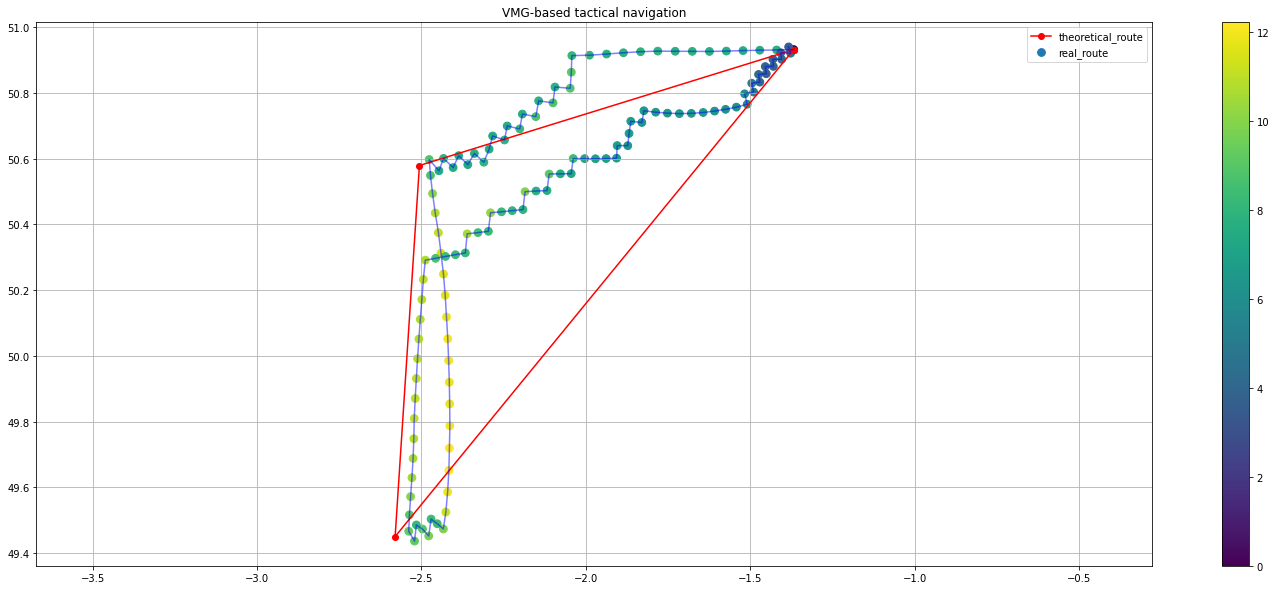

In [129]:
# Initialize Wind

# https://marine.meteoconsult.fr/cartes-meteo-marine/fichiers-grib.php 09 Manche Area 2020-09-19 8:20
grib_file_location = '/content/drive/My Drive/sailing_simulator/uLsEcMxxOoSYmtRzKDl0e75I4HAjqqDApv_.grb'

wind_forecast = Wind()
wind_forecast.acquire_grib_data(grib_file_location)


# Initialize Route : From Southampton to St Malo / Guernesey through Weymouth and back directly to SoTon. Departure at 10:00 Sunday 19th September 2020
starting_date = pandas.to_datetime('2020-09-19 06:00:00')
starting_point = Position(50.931429, -1.367399)
middle_point = Position(50.578713, -2.506107)

# St Malo
# end_point = Position(48.6465, -2.0066)

# Guernesey
end_point = Position(49.45, -2.58)


cruise = Route()
cruise.set_starting_point(starting_point.coordinates)
cruise.add_checkpoint(middle_point.coordinates)
cruise.add_checkpoint(end_point.coordinates)
cruise.add_checkpoint(starting_point.coordinates)

cruise.bearing_and_distance()
delta_T = 1200

print(cruise.minimal_distance)

n_checkpoints = len(cruise.checkpoint_list)

# Initialize Ship

# IMOCA foil 2019 polar curve
polar_file_location = '/content/drive/My Drive/sailing_simulator/polaires_imoca60_foil_2019.csv'

valou_crusader = Ship(starting_point, starting_date)
valou_crusader.acquire_polar_data(polar_file_location)


# Initialize Navigator
mode = 'vmg'
navigator = Navigator(mode=mode)

condition = True
t = 0

while condition:

    # Wind speed and direction from position
    wind_speed, wind_direction = wind_forecast.get_wind_info_from_position(valou_crusader.position, valou_crusader.date)

    # Distance and heading to next checkpoint from current position
    cruise.bearing_and_distance_to_checkpoint(valou_crusader.position)

    # Set heading following "mode" policy : shortest, VMG, other...
    navigator.heading_update(cruise, valou_crusader, wind_speed, wind_direction)
    valou_crusader.heading = navigator.heading

    # Ship speed at position from wind
    valou_crusader.get_speed(wind_speed, wind_direction)

    # Ship displacement
    valou_crusader.update_position(delta_T=delta_T)

    # Checkpoint crossing
    distance = valou_crusader.speed * delta_T / 3600
    cruise.checkpoint_crossing(distance)

    if t*delta_T % (3600) == 0:
        print(t, 
              valou_crusader.date, 
              valou_crusader.speed,
              round(valou_crusader.heading,0),
              round(valou_crusader.cumulated_distance / 1852,1), 
              cruise.distance_to_next_checkpoint, 
              cruise.route_status)
        
    if cruise.route_status+1 == n_checkpoints:
        condition = False
        print('Arrival at ', valou_crusader.date )
    else:
        # Update date
        valou_crusader.update_date(delta_T)
        t += 1

        if int(valou_crusader.date - wind_forecast.wind_data['u10'].time) > int(wind_forecast.timestep[-1]):
            print('time_out !')
            condition = False

# Display track
position_list = numpy.stack(valou_crusader.position_track)
speed_list = numpy.stack(valou_crusader.speed_track)
checkpoint_list = numpy.stack(cruise.checkpoint_list)

plt.figure(figsize=[25,10])
plt.plot(checkpoint_list[:,1], checkpoint_list[:, 0],'r',marker='o', label='theoretical_route')
plt.plot(position_list[:,1], 
        position_list[:,0],'b',
        alpha=0.5)
plt.scatter(c=speed_list, 
            s=60,
            x=position_list[:,1], 
            y=position_list[:,0], 
            alpha=1.0, label='real_route')
plt.axis('equal')
plt.legend()
plt.grid()
plt.colorbar()
plt.title('VMG-based tactical navigation')